In [1]:
import sys
sys.path.append('../utils')
sys.path.append('../core')
sys.path.append('../')
import numpy as np
import scipy
import tqdm
import utils
import geometry
from core import *

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import glob

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
test_phantom = phantom.Phantom(source_path = None,
            voxel_dims = (0.5e-3,0.5e-3,0.5e-3),
            matrix_dims = (100,100,100),
            baseline = (1500, 1000),
            seed = 5678,)

blood = tissue.Tissue(name='blood', c=1578, rho=1060, sigma=5.3, scale=0.00001, label=1)
myocardium = tissue.Tissue(name='myocardium', c=1561.3, rho=1081, sigma=30, scale=0.0001, label=2)
fat = tissue.Tissue(name='fat', c=1450, rho=920, sigma=0, scale=1, label=3)

pos = 0

# test_phantom.add_tissue_sphere((pos,-pos,0), 2, blood)
# test_phantom.add_tissue_sphere((pos,0,0), 4, blood)
# test_phantom.add_tissue_sphere((pos,pos,0), 8, blood)

# test_phantom.add_tissue_sphere((-pos,-pos,0), 4, fat)
# test_phantom.add_tissue_sphere((-pos,0,0), 8, fat)
# test_phantom.add_tissue_sphere((-pos,pos,0), 2, fat)

# test_phantom.add_tissue_sphere((0,-pos,0), 8, myocardium)
# test_phantom.add_tissue_sphere((0,0,0), 2, myocardium)
# test_phantom.add_tissue_sphere((0,pos,0), 4, myocardium)

test_phantom.add_tissue(fat, mask=np.ones(test_phantom.matrix_dims))
test_phantom.add_tissue_sphere((pos,0,0), 4, myocardium)
test_phantom.set_default_tissue('fat')
test = test_phantom.get_complete()
# test_phantom.add_tissue_sphere((0,-pos,0), 4, myocardium)


(50, 50, 50)


257


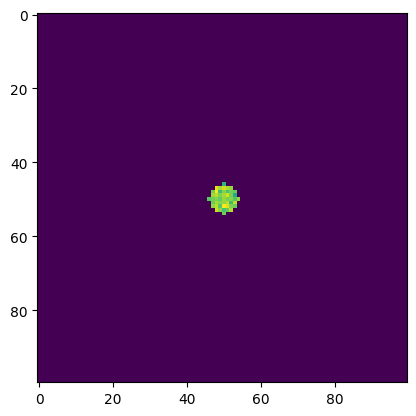

In [3]:
plt.imshow(test[0,:,:,test_phantom.matrix_dims[2]//2])
x = test_phantom.mask
print(np.sum(np.where(x != 3, 1, 0)))


In [148]:
# transducers = [transducer.Planewave(max_frequency=1e6,
#                                     elements = 96, 
#                                     width = 40e-3,
#                                     height =  10e-3,
#                                     sensor_sampling_scheme = 'not_centroid', 
#                                     sweep = np.pi/3,
#                                     ray_num = 64, 
#                                     imaging_ndims = 2,
#                                     focus_elevation = 50e-3,
#                                     ) for i in range(1)]

transducers = [transducer.Planewave(max_frequency=1e6,
                                    elements = 96, 
                                    width = 30e-3,
                                    height =  10e-3,
                                    sensor_sampling_scheme = 'not_centroid', 
                                    sweep = np.pi/8,
                                    ray_num = 12, 
                                    imaging_ndims = 2,
                                    focus_elevation = 50e-3,
                                    ) for i in range(1)]

for t in transducers:
    t.make_sensor_coords(test_phantom.baseline[0])

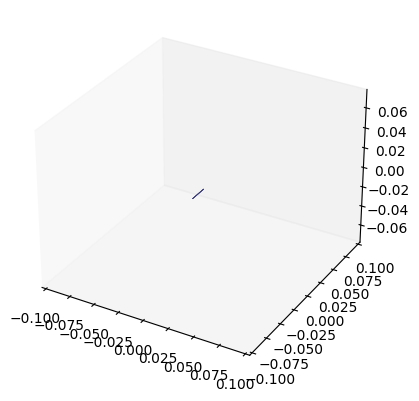

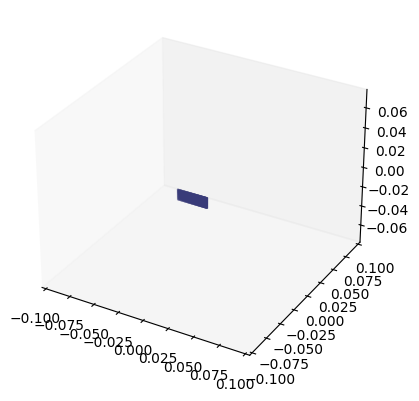

In [149]:
test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)
#test_transducer_set.generate_extrinsics(shape="spherical", extrinsics_kwargs={'r_mean': 1e-3, 'view_std': 0, 'yaw_fraction': 1, 'pitch_fraction': 0, 'roll_fraction': 0})
# test_transducer_set.assign_pose(0, geometry.Transform([-np.pi/6,0,0], [0,0.01,0]))
# test_transducer_set.assign_pose(1, geometry.Transform([np.pi/6,0,0], [0,-0.01,0]))
# test_transducer_set.assign_pose(0, geometry.Transform([-np.pi/20,0,0], [0,0.01,0]))
# test_transducer_set.assign_pose(1, geometry.Transform([np.pi/20,0,0], [0,-0.01,0]))

test_transducer_set.assign_pose(0, geometry.Transform([np.pi/2,0,0], [0,-0.02,0]))
test_transducer_set.plot_transducer_fovs(scale=0.1)
test_transducer_set.plot_transducer_coords(scale=0.1)

In [150]:
# test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='pressure_field')
test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='extended_aperture')

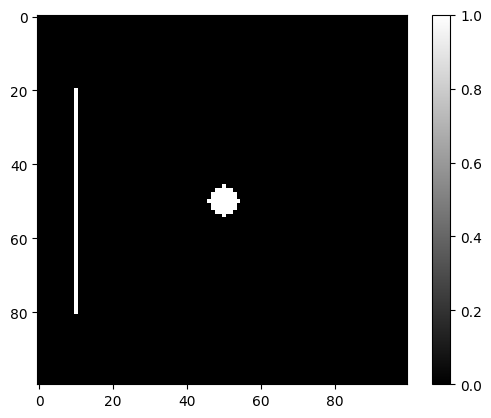

In [151]:
gm = test_sensor.visualize(test_phantom, test_phantom.matrix_dims[2]//2)

In [152]:
simprops = simulation.SimProperties(
                grid_size   = (50e-3,50e-3,30e-3),
                voxel_size  = (0.5e-3,0.5e-3,0.5e-3),
                PML_size    = (32,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [153]:
test_experiment = experiment.Experiment(
                 simulation_path = '../experiment_files/planewave_test_03',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = test_transducer_set,
                 sensor          = test_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 1,
                 additional_keys = ['p_max']
                 )

test_experiment.save()

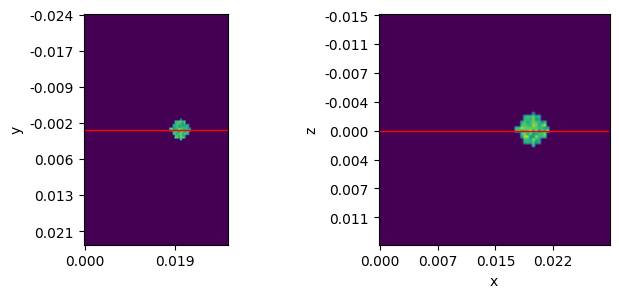

In [154]:
test_experiment.plot_ray_path(0)

In [155]:
# test_experiment.plot_ray_path(1)

In [156]:
test_experiment = experiment.Experiment.load('../experiment_files/planewave_test_03')
test_experiment.run(dry=True)

Number of simulation results (2) is less than the expected number of simulation results (12), are you sure the simulation finished running?
dry run of simulation


100%|██████████| 1/1 [00:00<00:00, 30.08it/s]

(1248, 3)
533.0
(1248, 3)
533.0


In [157]:
test_experiment.run(repeat=True)

running with 1 workers

(1248, 3)
1053.0
preparation for sim    0 completed in            1.18 seconds

(1248, 3)
1053.0
preparation for sim    1 completed in            1.11 seconds



┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
(1248, 3)
1053.0
preparation for sim    2 completed in            1.12 seconds

│ Selected GPU device id:                                     0 │
│ GPU device name:               NVIDIA RTX 6000 Ada Generation │
│ Number of CPU threads:                                     32 │
│ Processor name: AMD Ryzen Threadripper PRO 5955WX 16-Cores    │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                             144 x 144 x 96 │
│ Medium type:                                               3D │
│ Simulation time steps:                                    97

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:               NVIDIA RTX 6000 Ada Generation │
│ Number of CPU threads:                                     32 │
│ Processor name: AMD Ryzen Threadripper PRO 5955WX 16-Cores    │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                             144 x 144 x 96 │
│ Medium type:                                               3D │
│ Simulation time steps:                                    978 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:               NVIDIA RTX 6000 Ada Generation │
│ Number of CPU threads:                                     32 │
│ Processor name: AMD Ryzen Threadripper PRO 5955WX 16-Cores    │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                             144 x 144 x 96 │
│ Medium type:                                               3D │
│ Simulation time steps:                                    978 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:               NVIDIA RTX 6000 Ada Generation │
│ Number of CPU threads:                                     32 │
│ Processor name: AMD Ryzen Threadripper PRO 5955WX 16-Cores    │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                             144 x 144 x 96 │
│ Medium type:                                               3D │
│ Simulation time steps:                                    978 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:               NVIDIA RTX 6000 Ada Generation │
│ Number of CPU threads:                                     32 │
│ Processor name: AMD Ryzen Threadripper PRO 5955WX 16-Cores    │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                             144 x 144 x 96 │
│ Medium type:                                               3D │
│ Simulation time steps:                                    978 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:               NVIDIA RTX 6000 Ada Generation │
│ Number of CPU threads:                                     32 │
│ Processor name: AMD Ryzen Threadripper PRO 5955WX 16-Cores    │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                             144 x 144 x 96 │
│ Medium type:                                               3D │
│ Simulation time steps:                                    978 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:               NVIDIA RTX 6000 Ada Generation │
│ Number of CPU threads:                                     32 │
│ Processor name: AMD Ryzen Threadripper PRO 5955WX 16-Cores    │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                             144 x 144 x 96 │
│ Medium type:                                               3D │
│ Simulation time steps:                                    978 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:               NVIDIA RTX 6000 Ada Generation │
│ Number of CPU threads:                                     32 │
│ Processor name: AMD Ryzen Threadripper PRO 5955WX 16-Cores    │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                             144 x 144 x 96 │
│ Medium type:                                               3D │
│ Simulation time steps:                                    978 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
(1248, 3)
1053.0
preparation for sim   11 completed in            1.08 seconds

│ Selected GPU device id:                                     0 │
│ GPU device name:               NVIDIA RTX 6000 Ada Generation │
│ Number of CPU threads:                                     32 │
│ Processor name: AMD Ryzen Threadripper PRO 5955WX 16-Cores    │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                             144 x 144 x 96 │
│ Medium type:                                               3D │
│ Simulation time steps:                                    97

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:               NVIDIA RTX 6000 Ada Generation │
│ Number of CPU threads:                                     32 │
│ Processor name: AMD Ryzen Threadripper PRO 5955WX 16-Cores    │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                             144 x 144 x 96 │
│ Medium type:                                               3D │
│ Simulation time steps:                                    978 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:               NVIDIA RTX 6000 Ada Generation │
│ Number of CPU threads:                                     32 │
│ Processor name: AMD Ryzen Threadripper PRO 5955WX 16-Cores    │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                             144 x 144 x 96 │
│ Medium type:                                               3D │
│ Simulation time steps:                                    978 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:               NVIDIA RTX 6000 Ada Generation │
│ Number of CPU threads:                                     32 │
│ Processor name: AMD Ryzen Threadripper PRO 5955WX 16-Cores    │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                             144 x 144 x 96 │
│ Medium type:                                               3D │
│ Simulation time steps:                                    978 │
├───────────────────────────────────────────────────────────────┤
│         

In [158]:
test_experiment.add_results()

In [159]:
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

In [160]:
image = test_reconstruction.compound(workers=16, resolution_multiplier=2)

100%|██████████| 12/12 [00:00<00:00, 267721.53it/s]


transmit_rotation: [[ 2.220446e-16 -1.000000e+00  0.000000e+00]
 [ 1.000000e+00  2.220446e-16  0.000000e+00]
 [ 0.000000e+00  0.000000e+00  1.000000e+00]]
pw_rotation: [[ 0.98078528  0.19509032  0.        ]
 [-0.19509032  0.98078528  0.        ]
 [ 0.          0.          1.        ]]
rotation: [[ 0.19509032 -0.98078528  0.        ]
 [ 0.98078528  0.19509032  0.        ]
 [ 0.          0.          1.        ]]
normal: [0.19509032 0.98078528 0.        ]
transmit_rotation: [[ 2.220446e-16 -1.000000e+00  0.000000e+00]
 [ 1.000000e+00  2.220446e-16  0.000000e+00]
 [ 0.000000e+00  0.000000e+00  1.000000e+00]]
pw_rotation: [[ 0.98712358  0.1599595   0.        ]
 [-0.1599595   0.98712358  0.        ]
 [ 0.          0.          1.        ]]
rotation: [[ 0.1599595  -0.98712358  0.        ]
 [ 0.98712358  0.1599595   0.        ]
 [ 0.          0.          1.        ]]
normal: [0.1599595  0.98712358 0.        ]
transmit_rotation: [[ 2.220446e-16 -1.000000e+00  0.000000e+00]
 [ 1.000000e+00  2.220

100%|██████████| 12/12 [00:00<00:00, 185725.64it/s]


In [161]:
image.shape

(134, 134, 134)

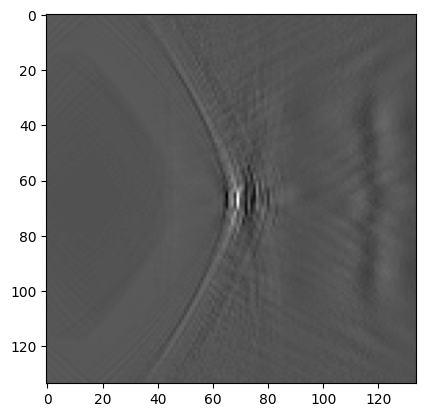

In [162]:
plt.imshow(image[:,:,image.shape[2]//2])

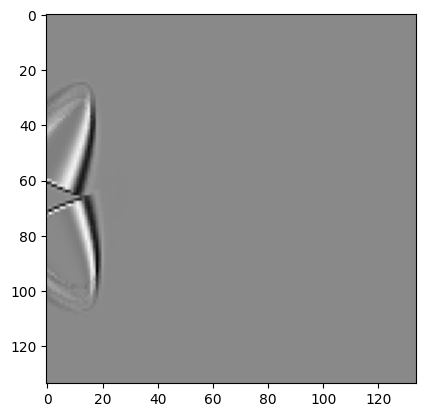

In [147]:
plt.imshow(image[:,:,image.shape[2]//2])

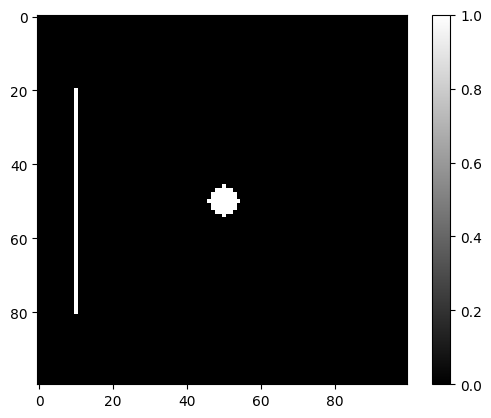

In [90]:
gm = test_experiment.sensor.visualize(test_experiment.phantom, test_experiment.phantom.matrix_dims[2]//2)

In [21]:
# element_15 = np.array([test_reconstruction.results[i][1][15] for i in range(len(test_reconstruction.results))])
# element_0 = np.array([test_reconstruction.results[i][1][0] for i in range(len(test_reconstruction.results))])

In [22]:
# plt.plot(element_15.T)

In [23]:
# plt.plot(element_0.T)

In [24]:
# test_reconstruction.results[0]

In [25]:
# plt.imshow(image[:,:,image.shape[2]//2])
# plt.colorbar()

In [26]:
# plt.imshow(test_phantom.get_complete()[0,:,:,test_phantom.matrix_dims[2]//2])

In [27]:
# plt.imshow(image[image.shape[0]//2,:,:])
# plt.colorbar()

In [28]:
# plt.imshow(image[:,image.shape[1]//2,:])
# plt.colorbar()

In [29]:
# plt.imshow(test_phantom.get_complete()[0,:,:,test_phantom.matrix_dims[2]//2])

In [30]:
# im = test_reconstruction.results[0][1]

In [31]:
# im.shape

In [32]:
# for frame in tqdm.tqdm(range(0,im.shape[-1],10)):
#     plt.imshow(im[:,:,frame], cmap='bwr')
#     plt.colorbar()
#     plt.savefig(f'../experiment_files/outputs/frame_{str(frame).zfill(4)}.png', dpi=50)
#     plt.close()